# Tutorial3: GAT implementation

## Outline

- Implementation of GAT

Official resources:
* [Code](https://dsgiitr.com/blogs/gat/)

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Structure

In [3]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """
    def __init__(self):
        super(GATLayer, self).__init__()

    def forward(self, input, adj):
        print("")

## Let's start from the forward method

### Linear Transformation

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
with $\textbf{W}\in\mathbb R^{F'\times F}$ and $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [4]:
in_features = 5
out_features = 2
nb_nodes = 3

W = nn.Parameter(torch.zeros(size=(in_features, out_features))) #xavier paramiter inizializator
nn.init.xavier_uniform_(W.data, gain=1.414)

input = torch.rand(nb_nodes,in_features)


# linear transformation
h = torch.mm(input, W)
N = h.size()[0]

print(h.shape)

torch.Size([3, 2])


### Attention Mechanism

![title](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/AttentionMechanism.png?raw=1)

In [5]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) #xavier paramiter inizializator
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU

torch.Size([4, 1])


In [6]:
a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)

Remark: Takes 9x4 matrix multiply with 4x1 vector will result 9x1 vector, where each coordinate is a attention coefficient between node i and node j

![title](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/a_input.png?raw=1)

In [7]:
e = leakyrelu(torch.matmul(a_input, a).squeeze(2))

In [ ]:
print(a_input.shape,a.shape)
print("")
print(torch.matmul(a_input,a).shape)
print("")
print(torch.matmul(a_input,a).squeeze(2).shape)

torch.Size([3, 3, 4]) torch.Size([4, 1])

torch.Size([3, 3, 1])

torch.Size([3, 3])


### Masked Attention

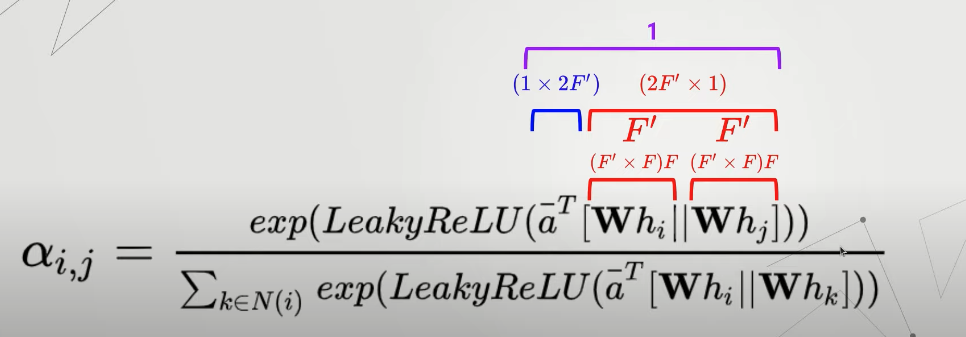

The masked attention (alpha) uses the e from above to calculate

In [ ]:
# Masked Attention
adj = torch.randint(2, (3, 3))

zero_vec  = -9e15*torch.ones_like(e)
print(zero_vec.shape)

torch.Size([3, 3])


In [ ]:
attention = torch.where(adj > 0, e, zero_vec)
print(adj,"\n",e,"\n",zero_vec)
attention

tensor([[0, 1, 0],
        [1, 0, 1],
        [0, 0, 0]]) 
 tensor([[0.6686, 1.1267, 1.0171],
        [0.8126, 1.2706, 1.1611],
        [0.7363, 1.1943, 1.0848]], grad_fn=<LeakyReluBackward0>) 
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


tensor([[-9.0000e+15,  1.1267e+00, -9.0000e+15],
        [ 8.1261e-01, -9.0000e+15,  1.1611e+00],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]], grad_fn=<SWhereBackward0>)

In [ ]:
attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)

In [ ]:
attention

tensor([[0.0000, 1.0000, 0.0000],
        [0.4138, 0.0000, 0.5862],
        [0.3333, 0.3333, 0.3333]], grad_fn=<SoftmaxBackward0>)

In [ ]:
h_prime

tensor([[ 0.0072,  1.0209],
        [-0.1147,  0.8389],
        [-0.0802,  0.8856]], grad_fn=<MmBackward0>)

#### h_prime vs h

In [ ]:
print(h_prime,"\n",h)

tensor([[ 0.0072,  1.0209],
        [-0.1147,  0.8389],
        [-0.0802,  0.8856]], grad_fn=<MmBackward0>) 
 tensor([[-0.1773,  0.6968],
        [ 0.0072,  1.0209],
        [-0.0706,  0.9392]], grad_fn=<MmBackward0>)


# Build the layer

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()

        '''
        TODO
        '''

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    #
        self.out_features  = out_features   #
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.


        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# Use it

In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Processing...
Done!


In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1


        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%200 == 0:
        print(loss)

    loss.backward()
    optimizer.step()



tensor(1.9471, grad_fn=<NllLossBackward0>)
tensor(0.7560, grad_fn=<NllLossBackward0>)
tensor(0.5531, grad_fn=<NllLossBackward0>)
tensor(0.5089, grad_fn=<NllLossBackward0>)
tensor(0.5936, grad_fn=<NllLossBackward0>)


In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8210
